In [35]:
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K


In [11]:
import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure

In [26]:
# initialize wandb and download dataset

hyperparams = {"num_epochs": 10, 
          "batch_size": 32,
          "height": 96,
          "width": 96}

wandb.init(config=hyperparams)
config = wandb.config

val_dir = 'catz/test'
train_dir = 'catz/train'

# automatically get the data if it doesn't exist
if not os.path.exists("catz"):
    print("Downloading catz dataset...")
    subprocess.check_output(
        "curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz", shell=True)

2021-10-16 18:28:53.086381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 18:28:53.086401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [27]:
# generator to loop over train and test images

def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.width, config.height, 3 * 5))
        output_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size


In [28]:
#callback to log the images

class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(15, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)

In [29]:
# Test the generator
gen = my_generator(2, train_dir)
videos, next_frame = next(gen)
videos[0].shape
next_frame[0].shape

(96, 96, 3)

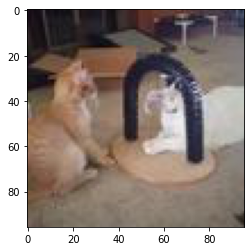

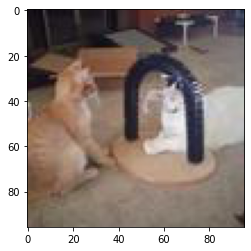

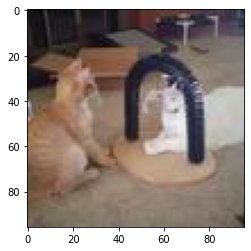

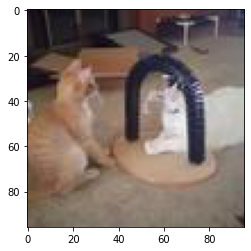

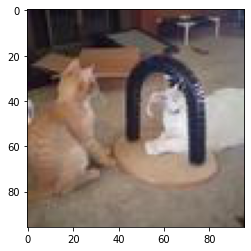

In [30]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,9:12])

figure()
imshow(next_frame[0][:,:,0:3])

In [36]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

In [37]:
wandb.init(config=hyperparams)
config = wandb.config

model = Sequential()
model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(config.height, config.width, 5 * 3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

2021-10-16 18:32:55.412217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 18:32:55.412235: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/10
52/52 [==============================] - 7s 131ms/step - loss: 0.1695 - perceptual_distance: 255.1319 - val_loss: 0.1248 - val_perceptual_distance: 217.5594
Epoch 2/10
52/52 [==============================] - 7s 132ms/step - loss: 0.1248 - perceptual_distance: 217.1062 - val_loss: 0.1208 - val_perceptual_distance: 212.8850
Epoch 3/10
52/52 [==============================] - 7s 133ms/step - loss: 0.0697 - perceptual_distance: 148.2080 - val_loss: 0.0249 - val_perceptual_distance: 83.1501
Epoch 4/10
52/52 [==============================] - 7s 130ms/step - loss: 0.0184 - perceptual_distance: 71.1164 - val_loss: 0.0140 - val_perceptual_distance: 60.6479
Epoch 5/10
52/52 [==============================] - 7s 134ms/step - loss: 0.0133 - perceptual_distance: 57.4686 - val_loss: 0.0115 - val_perceptual_distance: 52.4305
Epoch 6/10
52/52 [==============================] - 7s 140ms/step - loss: 0.0105 - perceptual_distance: 50.7786 - val_loss: 0.0094 - val_perceptual_distance: 47.3945

In [38]:
# Baseline model - just return the last layer

from keras.layers import Lambda, Reshape, Permute

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

model=Sequential()
model.add(Reshape((96,96,5,3), input_shape=(config.height, config.width, 5 * 3)))
model.add(Permute((1,2,4,3)))
model.add(Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▁▁▁▁▁▁▁
perceptual_distance,█▇▅▂▂▁▁▁▁▁
val_loss,██▂▁▁▁▁▁▁▁
val_perceptual_distance,██▃▂▂▁▁▁▁▁
best_epoch,8
best_val_loss,0.00777
epoch,9
loss,0.00798
perceptual_distance,40.15995
val_loss,0.00798


2021-10-16 18:40:25.059465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 18:40:25.059484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/10
52/52 [==============================] - 6s 107ms/step - loss: 0.0066 - perceptual_distance: 21.3525 - val_loss: 0.0040 - val_perceptual_distance: 17.4457
Epoch 2/10
52/52 [==============================] - 5s 107ms/step - loss: 0.0057 - perceptual_distance: 20.6578 - val_loss: 0.0044 - val_perceptual_distance: 18.0904
Epoch 3/10
52/52 [==============================] - 5s 107ms/step - loss: 0.0058 - perceptual_distance: 21.0087 - val_loss: 0.0045 - val_perceptual_distance: 18.1615
Epoch 4/10
52/52 [==============================] - 5s 102ms/step - loss: 0.0054 - perceptual_distance: 19.5008 - val_loss: 0.0054 - val_perceptual_distance: 19.6066
Epoch 5/10
52/52 [==============================] - 5s 105ms/step - loss: 0.0064 - perceptual_distance: 21.3144 - val_loss: 0.0053 - val_perceptual_distance: 18.8234
Epoch 6/10
52/52 [==============================] - 5s 106ms/step - loss: 0.0054 - perceptual_distance: 20.7158 - val_loss: 0.0047 - val_perceptual_distance: 18.3632
Epoc

In [39]:
# Just return the last layer, functional style

from keras.layers import Lambda, Reshape, Permute, Input
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
model=Model(inputs=[inp], outputs=[last_layer])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▄▁▇▂▅▁▁▁
perceptual_distance,█▆▇▂█▆█▃▁▅
val_loss,▁▃▄█▇▄█▃█▇
val_perceptual_distance,▁▂▃▆▄▃▄▄█▅
best_epoch,0
best_val_loss,0.004
epoch,9
loss,0.00539
perceptual_distance,20.43683
val_loss,0.00514


2021-10-16 18:41:48.301150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 18:41:48.301171: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/10
52/52 [==============================] - 5s 103ms/step - loss: 0.0054 - perceptual_distance: 20.4609 - val_loss: 0.0068 - val_perceptual_distance: 22.1922
Epoch 2/10
52/52 [==============================] - 5s 105ms/step - loss: 0.0055 - perceptual_distance: 20.4319 - val_loss: 0.0044 - val_perceptual_distance: 18.5040
Epoch 3/10
52/52 [==============================] - 5s 105ms/step - loss: 0.0058 - perceptual_distance: 21.2376 - val_loss: 0.0043 - val_perceptual_distance: 16.5071
Epoch 4/10
52/52 [==============================] - 5s 106ms/step - loss: 0.0061 - perceptual_distance: 21.6107 - val_loss: 0.0049 - val_perceptual_distance: 19.7094
Epoch 5/10
52/52 [==============================] - 5s 107ms/step - loss: 0.0052 - perceptual_distance: 19.7567 - val_loss: 0.0052 - val_perceptual_distance: 19.9776
Epoch 6/10
52/52 [==============================] - 5s 106ms/step - loss: 0.0063 - perceptual_distance: 21.9258 - val_loss: 0.0066 - val_perceptual_distance: 21.4197
Epoc

In [40]:
# Conv3D

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

hyperparams["num_epochs"] = 100
wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
conv_output = Conv3D(1, (3,3,3), padding="same")(permuted)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▃▃▄▅▆▆▇█
loss,▃▄▅▇▂█▆▁█▆
perceptual_distance,▃▃▆▇▁█▇▁▇▆
val_loss,█▁▁▃▃▇▁▄▄▆
val_perceptual_distance,█▃▁▅▅▇▅▄▆▇
best_epoch,2
best_val_loss,0.00428
epoch,9
loss,0.00588
perceptual_distance,21.26282
val_loss,0.00598


2021-10-16 18:43:23.393874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 18:43:23.393893: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/100
52/52 [==============================] - 16s 304ms/step - loss: 0.0379 - perceptual_distance: 101.9387 - val_loss: 0.0232 - val_perceptual_distance: 66.2158


/home/sraj/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
52/52 [==============================] - 17s 325ms/step - loss: 0.0214 - perceptual_distance: 64.6084 - val_loss: 0.0173 - val_perceptual_distance: 58.4603
Epoch 3/100
52/52 [==============================] - 18s 342ms/step - loss: 0.0147 - perceptual_distance: 54.0755 - val_loss: 0.0128 - val_perceptual_distance: 51.7342
Epoch 4/100
52/52 [==============================] - 18s 346ms/step - loss: 0.0129 - perceptual_distance: 49.1505 - val_loss: 0.0093 - val_perceptual_distance: 44.2887
Epoch 5/100
52/52 [==============================] - 17s 330ms/step - loss: 0.0117 - perceptual_distance: 46.8485 - val_loss: 0.0089 - val_perceptual_distance: 42.2610
Epoch 6/100
52/52 [==============================] - 16s 315ms/step - loss: 0.0098 - perceptual_distance: 43.5138 - val_loss: 0.0090 - val_perceptual_distance: 41.8867
Epoch 7/100
52/52 [==============================] - 16s 308ms/step - loss: 0.0081 - perceptual_distance: 39.6689 - val_loss: 0.0075 - val_perceptual_distance: 

52/52 [==============================] - 15s 296ms/step - loss: 0.0059 - perceptual_distance: 27.8577 - val_loss: 0.0046 - val_perceptual_distance: 28.3182
Epoch 51/100
52/52 [==============================] - 16s 299ms/step - loss: 0.0052 - perceptual_distance: 26.8659 - val_loss: 0.0045 - val_perceptual_distance: 24.1292
Epoch 52/100
52/52 [==============================] - 16s 301ms/step - loss: 0.0059 - perceptual_distance: 27.2921 - val_loss: 0.0063 - val_perceptual_distance: 30.1169
Epoch 53/100
52/52 [==============================] - 15s 298ms/step - loss: 0.0066 - perceptual_distance: 28.8779 - val_loss: 0.0065 - val_perceptual_distance: 26.5542
Epoch 54/100
52/52 [==============================] - 16s 299ms/step - loss: 0.0051 - perceptual_distance: 26.3142 - val_loss: 0.0043 - val_perceptual_distance: 23.3967
Epoch 55/100
52/52 [==============================] - 15s 298ms/step - loss: 0.0059 - perceptual_distance: 27.7941 - val_loss: 0.0055 - val_perceptual_distance: 34.7080

52/52 [==============================] - 16s 301ms/step - loss: 0.0049 - perceptual_distance: 25.1727 - val_loss: 0.0047 - val_perceptual_distance: 23.6609
Epoch 99/100
52/52 [==============================] - 16s 300ms/step - loss: 0.0052 - perceptual_distance: 25.4410 - val_loss: 0.0054 - val_perceptual_distance: 24.8500
Epoch 100/100
52/52 [==============================] - 16s 302ms/step - loss: 0.0052 - perceptual_distance: 25.1620 - val_loss: 0.0057 - val_perceptual_distance: 23.3773


In [41]:
# Conv3D with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init()

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
conv_output = Conv3D(1, (3,3,3), padding="same")(noise)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perceptual_distance,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁▂▂▂▁▁▂
val_perceptual_distance,█▆▄▄▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▂▂▁▂▁▂▂▂▁▁▁
best_epoch,80
best_val_loss,0.00367
epoch,99
loss,0.00525
perceptual_distance,25.16198
val_loss,0.00566


2021-10-16 19:10:57.878917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 19:10:57.878939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/100
52/52 [==============================] - 17s 319ms/step - loss: 0.0515 - perceptual_distance: 153.1254 - val_loss: 0.0125 - val_perceptual_distance: 50.8542
Epoch 2/100
52/52 [==============================] - 17s 318ms/step - loss: 0.0290 - perceptual_distance: 115.4228 - val_loss: 0.0095 - val_perceptual_distance: 43.5439
Epoch 3/100
52/52 [==============================] - 16s 315ms/step - loss: 0.0262 - perceptual_distance: 108.7641 - val_loss: 0.0083 - val_perceptual_distance: 39.0075
Epoch 4/100
52/52 [==============================] - 16s 317ms/step - loss: 0.0233 - perceptual_distance: 102.5848 - val_loss: 0.0081 - val_perceptual_distance: 39.0616
Epoch 5/100
52/52 [==============================] - 17s 318ms/step - loss: 0.0213 - perceptual_distance: 96.9932 - val_loss: 0.0076 - val_perceptual_distance: 35.5262
Epoch 6/100
52/52 [==============================] - 16s 317ms/step - loss: 0.0199 - perceptual_distance: 92.7531 - val_loss: 0.0059 - val_perceptual_distan

52/52 [==============================] - 17s 324ms/step - loss: 0.0066 - perceptual_distance: 38.9709 - val_loss: 0.0045 - val_perceptual_distance: 24.9852
Epoch 50/100
52/52 [==============================] - 17s 324ms/step - loss: 0.0067 - perceptual_distance: 38.4472 - val_loss: 0.0040 - val_perceptual_distance: 24.1406
Epoch 51/100
52/52 [==============================] - 17s 325ms/step - loss: 0.0062 - perceptual_distance: 37.8615 - val_loss: 0.0065 - val_perceptual_distance: 28.5038
Epoch 52/100
52/52 [==============================] - 17s 325ms/step - loss: 0.0063 - perceptual_distance: 38.3514 - val_loss: 0.0045 - val_perceptual_distance: 26.0881
Epoch 53/100
52/52 [==============================] - 17s 322ms/step - loss: 0.0056 - perceptual_distance: 36.4651 - val_loss: 0.0068 - val_perceptual_distance: 30.1703
Epoch 54/100
52/52 [==============================] - 17s 322ms/step - loss: 0.0071 - perceptual_distance: 39.3579 - val_loss: 0.0047 - val_perceptual_distance: 26.4265

52/52 [==============================] - 17s 328ms/step - loss: 0.0074 - perceptual_distance: 40.6436 - val_loss: 0.0063 - val_perceptual_distance: 37.2117
Epoch 98/100
52/52 [==============================] - 17s 324ms/step - loss: 0.0073 - perceptual_distance: 40.1386 - val_loss: 0.0062 - val_perceptual_distance: 28.2134
Epoch 99/100
52/52 [==============================] - 17s 327ms/step - loss: 0.0067 - perceptual_distance: 38.6850 - val_loss: 0.0055 - val_perceptual_distance: 28.5188
Epoch 100/100
52/52 [==============================] - 17s 324ms/step - loss: 0.0068 - perceptual_distance: 38.4581 - val_loss: 0.0046 - val_perceptual_distance: 26.5220


In [42]:
# Conv2DLSTM with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(6, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(3, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perceptual_distance,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▄▁▃▁▂▂▁▂▂▄▂▁▁▃▂▂▂▄▁▁▁▂▂▁▂▂▂▁▂▂▁▃▂
val_perceptual_distance,█▅▃▃▃▃▂▃▁▂▁▂▂▃▂▂▂▂▂▁▂▂▂▂▃▂▁▂▂▂▂▂▂▂▁▃▂▁▄▂
best_epoch,25
best_val_loss,0.00392
epoch,99
loss,0.00676
perceptual_distance,38.45805
val_loss,0.00463


2021-10-16 19:40:16.987264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 19:40:16.987285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/100
52/52 [==============================] - 71s 1s/step - loss: 0.0172 - perceptual_distance: 84.5598 - val_loss: 0.0060 - val_perceptual_distance: 27.5941
Epoch 2/100
52/52 [==============================] - 70s 1s/step - loss: 0.0160 - perceptual_distance: 80.3691 - val_loss: 0.0050 - val_perceptual_distance: 26.2962
Epoch 3/100
52/52 [==============================] - 75s 1s/step - loss: 0.0155 - perceptual_distance: 78.2660 - val_loss: 0.0055 - val_perceptual_distance: 23.9553
Epoch 4/100
52/52 [==============================] - 72s 1s/step - loss: 0.0139 - perceptual_distance: 75.0605 - val_loss: 0.0041 - val_perceptual_distance: 23.9068
Epoch 5/100
52/52 [==============================] - 71s 1s/step - loss: 0.0137 - perceptual_distance: 72.4610 - val_loss: 0.0064 - val_perceptual_distance: 29.4156
Epoch 6/100
52/52 [==============================] - 70s 1s/step - loss: 0.0120 - perceptual_distance: 67.7059 - val_loss: 0.0062 - val_perceptual_distance: 29.1079
Epoch 7/10

KeyboardInterrupt: 

In [ ]:
# Conv2DLSTM with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▇▇▅▅▄▃▂▂▂▁▁
perceptual_distance,█▇▇▆▅▄▄▃▂▂▁▁
val_loss,▆▃▅▁▇▇▃▃▆█▄▇
val_perceptual_distance,▄▃▁▁▆▆▅▅▆█▅▆
best_epoch,3
best_val_loss,0.00409
epoch,11
loss,0.00792
perceptual_distance,51.0038
val_loss,0.00614


2021-10-16 19:56:08.219321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 19:56:08.219349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1/100
